In [187]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gpytorch.priors import GammaPrior
import torch
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import gpytorch


In [482]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(lengthscale = 1e1), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [483]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [484]:

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['ABETA_bl','PTAU_bl', 'TAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 3) (109, 3)


In [485]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [486]:

noise_prior = GammaPrior(concentration=1.1, rate=0.05)
num_tasks = 3
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)
# likelihood.noise = 0.5
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -1.55:
    model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finially intialized with likelihood: {initial_likelihood}')


model.train()
likelihood.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay = 1e-5, maximize=True)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150], gamma=0.1)

Model finially intialized with likelihood: -1.5213552713394165


In [487]:
training_loss = []
test_losses = []

In [488]:

num_iter = 500
for i in range(num_iter):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = mll(output, y_train)
    loss.backward()
    training_loss.append(loss.item())
    
    optimizer.step()
    model.eval()
    test_output = model(X_test)
    test_loss = mll(test_output, y_test)
    test_losses.append(test_loss.item())
    
    #scheduler.step()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()



Iter 1/500 - Loss: -1.521
Iter 2/500 - Loss: -1.474
Iter 3/500 - Loss: -1.427
Iter 4/500 - Loss: -1.381
Iter 5/500 - Loss: -1.338
Iter 6/500 - Loss: -1.295
Iter 7/500 - Loss: -1.255
Iter 8/500 - Loss: -1.218
Iter 9/500 - Loss: -1.181
Iter 10/500 - Loss: -1.145
Iter 11/500 - Loss: -1.113
Iter 12/500 - Loss: -1.084
Iter 13/500 - Loss: -1.055
Iter 14/500 - Loss: -1.026
Iter 15/500 - Loss: -0.999
Iter 16/500 - Loss: -0.977
Iter 17/500 - Loss: -0.958
Iter 18/500 - Loss: -0.943
Iter 19/500 - Loss: -0.927
Iter 20/500 - Loss: -0.908
Iter 21/500 - Loss: -0.889
Iter 22/500 - Loss: -0.870
Iter 23/500 - Loss: -0.850
Iter 24/500 - Loss: -0.828
Iter 25/500 - Loss: -0.807
Iter 26/500 - Loss: -0.789
Iter 27/500 - Loss: -0.773
Iter 28/500 - Loss: -0.756
Iter 29/500 - Loss: -0.740
Iter 30/500 - Loss: -0.725
Iter 31/500 - Loss: -0.708
Iter 32/500 - Loss: -0.691
Iter 33/500 - Loss: -0.675
Iter 34/500 - Loss: -0.660
Iter 35/500 - Loss: -0.645
Iter 36/500 - Loss: -0.633
Iter 37/500 - Loss: -0.622
Iter 38/50

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
  (raw_noise_prior): GammaPrior()
)

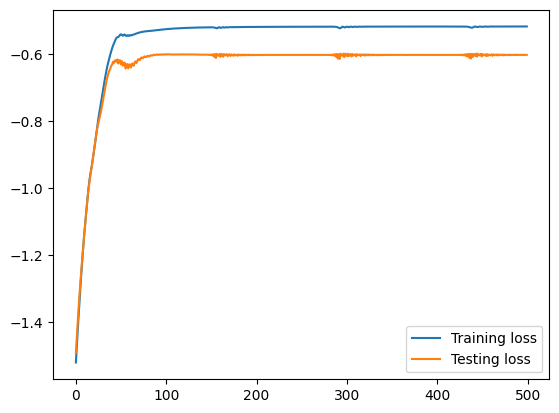

In [489]:
plt.plot(training_loss, label='Training loss')
plt.plot(test_losses,label='Testing loss')
plt.legend()
plt.show()

In [490]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')

Parameter name: likelihood.task_noise_covar_factor         value = [[-0.3658547103404999], [-0.546842634677887], [-0.6064895391464233]]
Parameter name: likelihood.raw_noise                       value = [-4.975107192993164]
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.2607114911079407], [-1.1939822435379028], [-1.17572021484375]]
Parameter name: covar_module.task_covar_module.raw_var     value = [1.1018221378326416, -4.817032814025879, -4.350623607635498]
Parameter name: covar_module.data_covar_module.raw_lengthscale value = [[10.390325546264648]]
Parameter name: covar_module.data_covar_module.raw_alpha   value = [-1.938147783279419]


In [491]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Target 1: MSE = 0.0982, RMSE = 0.3133, R2 = 0.8998
Target 2: MSE = 0.2107, RMSE = 0.4590, R2 = 0.7842
Target 3: MSE = 0.2759, RMSE = 0.5253, R2 = 0.7146


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Target 1: MSE = 0.3953, RMSE = 0.6287, R2 = 0.6344
Target 2: MSE = 0.6681, RMSE = 0.8174, R2 = 0.3891
Target 3: MSE = 0.7741, RMSE = 0.8798, R2 = 0.3161


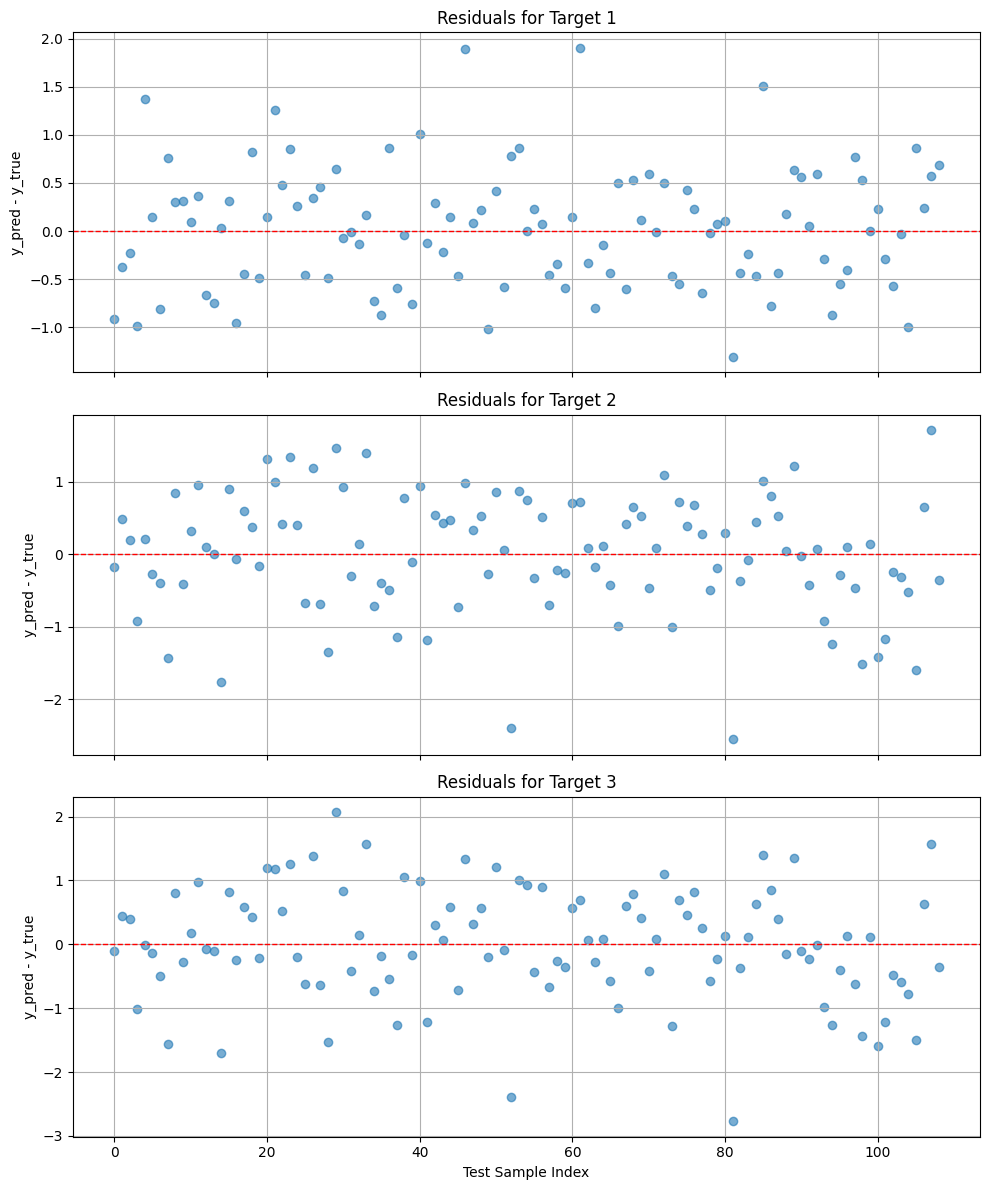

In [492]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

# Plot residuals for each target
fig, axs = plt.subplots(num_targets, 1, figsize=(10, 4 * num_targets), sharex=True)

for i in range(num_targets):
    residuals = y_pred_np[:, i] - y_true_np[:, i]

    axs[i].scatter(range(len(residuals)), residuals, alpha=0.6)
    axs[i].axhline(0, color='red', linestyle='--', linewidth=1)
    axs[i].set_title(f"Residuals for Target {i+1}")
    axs[i].set_ylabel("y_pred - y_true")
    axs[i].grid(True)

plt.xlabel("Test Sample Index")
plt.tight_layout()
plt.show()

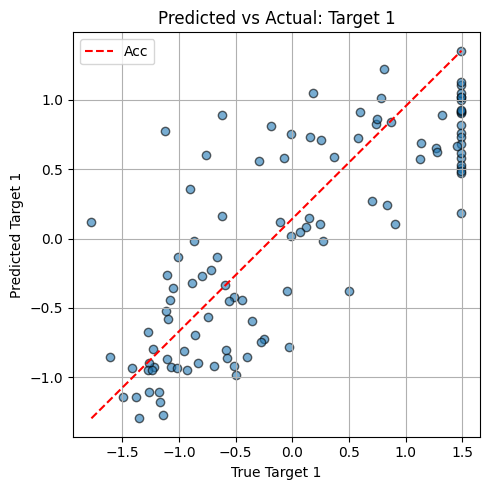

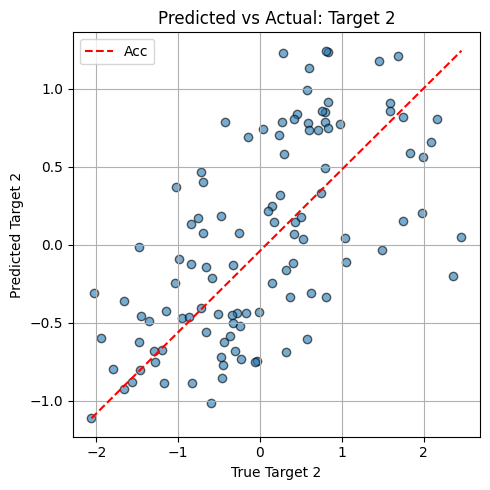

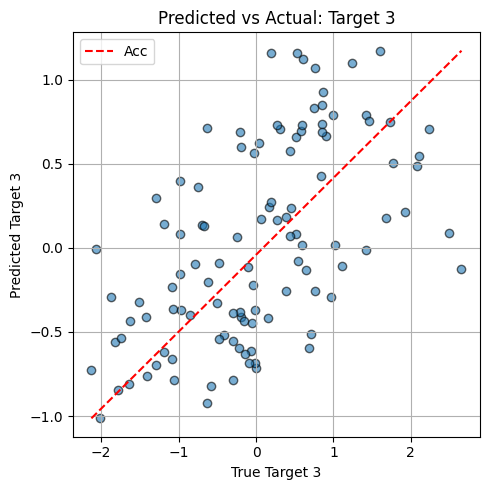

In [446]:
for i in range(y_test.shape[1]):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test[:, i].numpy(), mean[:, i].numpy(), alpha=0.6, edgecolors='k')
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_pred_np[:, i].min(), y_pred_np[:, i].max()], 'r--', label='Acc')

    plt.xlabel(f"True Target {i+1}")
    plt.ylabel(f"Predicted Target {i+1}")
    plt.title(f"Predicted vs Actual: Target {i+1}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# STL
## ABETA


In [247]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(alpha = 0.01, lengthscale = 1e-2), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [261]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['PTAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 1) (109, 1)


In [262]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [270]:
num_tasks = 1
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1)
likelihood.noise = 0.5
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)

In [271]:
model.train()
likelihood.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay = 1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

num_iter = 100
for i in range(num_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()

Iter 1/100 - Loss: 1.758
Iter 2/100 - Loss: 1.659
Iter 3/100 - Loss: 1.569
Iter 4/100 - Loss: 1.488
Iter 5/100 - Loss: 1.414
Iter 6/100 - Loss: 1.346
Iter 7/100 - Loss: 1.285
Iter 8/100 - Loss: 1.231
Iter 9/100 - Loss: 1.182
Iter 10/100 - Loss: 1.137
Iter 11/100 - Loss: 1.093
Iter 12/100 - Loss: 1.048
Iter 13/100 - Loss: 1.003
Iter 14/100 - Loss: 0.958
Iter 15/100 - Loss: 0.914
Iter 16/100 - Loss: 0.872
Iter 17/100 - Loss: 0.834
Iter 18/100 - Loss: 0.798
Iter 19/100 - Loss: 0.765
Iter 20/100 - Loss: 0.734
Iter 21/100 - Loss: 0.704
Iter 22/100 - Loss: 0.677
Iter 23/100 - Loss: 0.653
Iter 24/100 - Loss: 0.632
Iter 25/100 - Loss: 0.614
Iter 26/100 - Loss: 0.600
Iter 27/100 - Loss: 0.590
Iter 28/100 - Loss: 0.582
Iter 29/100 - Loss: 0.576
Iter 30/100 - Loss: 0.571
Iter 31/100 - Loss: 0.567
Iter 32/100 - Loss: 0.562
Iter 33/100 - Loss: 0.556
Iter 34/100 - Loss: 0.548
Iter 35/100 - Loss: 0.540
Iter 36/100 - Loss: 0.534
Iter 37/100 - Loss: 0.533
Iter 38/100 - Loss: 0.533
Iter 39/100 - Loss: 0

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [272]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Target 1: MSE = 0.0054, RMSE = 0.0738, R2 = 0.9769


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [273]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

Target 1: MSE = 0.1681, RMSE = 0.4100, R2 = 0.3632
